Construction of the Yield Curve using the UST website datafeed and Natural Log Cubic Interpolation with QuantLib: We use bootstrapping on the UST Par Yield Curve to get the spot rates at each maturity.

Constructed the US Yield Curve using the UST website datafeed. I gathered data from the UST website on UST Par Yield Curve and used bootstrapping to compute spot rates at each maturity. Using the QuantLib library and a bond helper function I created the yield curve. I applied Natural Log Cubic Interpolation to smoothen the short-end of the curve.

We first load all the conventions from the QuantLib library.

We then get the XML feed from the UST website and parse the data.

We create bond helpers listing bond properties, including their par yields, on fixed bonds at each maturity date.

We need to smoothen the short-end of our Yield Curve. We apply cubic interpolation to the logarithms of discount factor, rather than directly discount factos.

We apply the bootstrapping method and get the spot rates.

We plot the curve and we get the 10Y UST discount factor.

In [4]:
import QuantLib as ql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import xml.etree.ElementTree as ET
from datetime import datetime

In [5]:
class UST_spot_YieldCurve:
    def __init__(self, date: ql.Date) -> None:
        self.as_of_date = date
        ql.Settings.instance().evaluationDate = self.as_of_date
        self.api_str = f"{self.as_of_date.year()}{self.as_of_date.month():02d}"
        self.api_url = f"https://home.treasury.gov/resource-center/data-chart-center/interest-rates/pages/xml?data=daily_treasury_yield_curve&field_tdr_date_value_month={self.api_str}"
        self.raw_data = {}
        self.par_yields = self.get_raw_xml_data()
        if len(self.raw_data) > 2 :
            print("Fetched raw data from USDT website!")
        else:
            raise Exception("Error fetching data from USDT website!")

        # Conventions via QuantLib
        self.calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        self.business_convention = ql.ModifiedFollowing
        self.day_count = ql.ActualActual(ql.ActualActual.ISDA)
        self.settlement_days = 1
        self.face_amount = 100
        self.coupon_frequency = ql.Period(ql.Semiannual)
        self.end_of_month = False

        # Calibrate the yield curve
        self.calibrate()
        
    #Get discount factor on given maturity via the YC
    def get_discount_factor(self, date: ql.Date):
        return self.yield_curve.discount(date)
    
    #Create handle to allow objects to reference the YC
    def get_YC_handle(self):
        if self.yield_curve is not None:
            return ql.YieldTermStructureHandle(self.yield_curve)
        else:
            raise Exception("Error calibrating yield curve!")

    def get_raw_xml_data(self):
        response = requests.get(self.api_url)

        if response.status_code == 200:
            # Parse the XML content
            root = ET.fromstring(response.content)

            # Define namespaces, with Atom feed (data feed), m for metadata and d for data elements of the XML
            namespaces = {
                'atom': 'http://www.w3.org/2005/Atom',
                'm': 'http://schemas.microsoft.com/ado/2007/08/dataservices/metadata',
                'd': 'http://schemas.microsoft.com/ado/2007/08/dataservices'
            }

            # Find all entry tags
            entries = root.findall('.//atom:entry', namespaces)

            # Iterate through each entry tag
            for entry in entries:
                # Find the properties and content, inside each entry tag
                content = entry.find('atom:content', namespaces)
                properties = content.find('m:properties', namespaces)
                if properties is not None:
                    # Iterate through each property
                    # Extract the target date (NEW_DATE) property, in the d namespace, and convert it to a datetime object
                    new_date_str = properties.find('d:NEW_DATE', namespaces).text
                    new_date = datetime.strptime(new_date_str, "%Y-%m-%dT%H:%M:%S")

                    if ql.Date(new_date.day, new_date.month, new_date.year) == self.as_of_date:
                        #Loop that iterates through properties to find BC_ which gives a bond yield for a specific tenor
                        for prop in properties:
                            if (prop.tag.startswith('{http://schemas.microsoft.com/ado/2007/08/dataservices}BC_') 
                            and prop.tag != '{http://schemas.microsoft.com/ado/2007/08/dataservices}BC_30YEARDISPLAY'):
                                tag = prop.tag.split('}')[1]  # Remove namespace from the tag and keeping only the element name BC_XXX
                                period_str = tag.split("BC_")[1].replace("MONTH","M").replace("YEAR","Y")
                                ql_period = ql.Period(period_str)
                                raw_yield = float(prop.text)
                                self.raw_data.update({ql_period:raw_yield})                

        else:
            print("Failed to fetch XML data. Status code:", response.status_code)

    def get_spot_rates(self, months=360):
        spots = []
        tenors = []
        ref_date = self.as_of_date + self.settlement_days
        calc_date = ref_date
        for month in range(0, months):
            yrs = month / 12.0
            compounding = ql.Compounded
            freq = ql.Semiannual
            #Advances the ref_date by 'month' to compute the next spot rate
            d = self.calendar.advance(ref_date, ql.Period(month, ql.Months))

            #finds the ZC rate for the maturity 'yrs' on the YC, and stores the time to maturity
            zero_rate = self.yield_curve.zeroRate(yrs, compounding, freq)
            tenors.append(yrs)

            #We annualize the ZC rate and store it
            eq_rate = zero_rate.equivalentRate(
                self.day_count, compounding, freq, calc_date, d
            ).rate()
            spots.append(100 * eq_rate)
            
        return pd.DataFrame(
            list(zip(tenors, spots)),
            columns=["Maturities", "Zero Rates(%)"],
            index=[""] * len(tenors),
        )

    def calibrate(self):
        bond_helpers = []
        #All yields on the par yield curve provided by the UST website are on a bond-equivalent basis with semiannual compounding

        for tenor, par_yield in self.raw_data.items():
            maturity_date = self.as_of_date + tenor
            #Generate schedule of coupon payements with QL
            schedule = ql.Schedule(
                self.as_of_date,
                maturity_date,
                self.coupon_frequency,
                self.calendar,
                self.business_convention,
                self.business_convention,
                ql.DateGeneration.Backward,
                self.end_of_month,
            )
            #Generate the list of bonds, and connect the yields observed
            bond_helper = ql.FixedRateBondHelper(
                ql.QuoteHandle(ql.SimpleQuote(self.face_amount)),
                self.settlement_days,
                self.face_amount,
                schedule,
                [par_yield / 100.0],
                self.day_count,
                self.business_convention,
            )
            bond_helpers.append(bond_helper)
        print("Listed bond helpers with par yields for all maturities!")

        #YC is not smoothed especially at short end
        #We apply cubic interpolation to the logarithms of discount factor, rather than directly discount factos
        self.yield_curve = ql.PiecewiseNaturalLogCubicDiscount(
            self.as_of_date, bond_helpers, self.day_count
        )
        self.yield_curve.enableExtrapolation()
        print("The UST Spot Yield Curve is calibrated!")

Fetched raw data from USDT website!
Listed bond helpers with par yields for all maturities!
The UST Spot Yield Curve is calibrated!
As of the October 25th, 2024, the discount factor on a 10Y UST is 0.6551522857415304


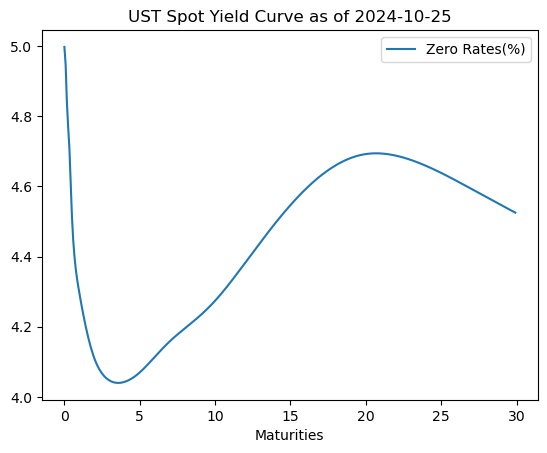

In [6]:
as_of_date = ql.Date(25, 10, 2024)
us_yield_curve = UST_spot_YieldCurve(date=as_of_date)
spot_rates = us_yield_curve.get_spot_rates(months=360)
spot_rates.plot(x="Maturities", y="Zero Rates(%)", title=f"UST Spot Yield Curve as of {as_of_date.ISO()}")
print(f"As of the {as_of_date}, the discount factor on a 10Y UST is {us_yield_curve.get_discount_factor(date=ql.Date(25, 10, 2034))}")